# Machine Learning Potpourri

## Sample Binary Classification Setup

In [40]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

## Plotting Histogram with Fitted Normal Distribution

In [43]:
df = pd.DataFrame(X)

In [61]:
def hist_with_normal(df,bin_count=25):
    import numpy as np
    from scipy.stats import norm
    import matplotlib.pyplot as plt
   
    # Fit a normal distribution to
    # the data:
    # mean and standard deviation
    mu, std = norm.fit(df) 
    
    # Plot the histogram.
    plt.hist(df, bins=bin_count, density=True, alpha=0.6, color='b')
    
    # Plot the PDF.
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    
    plt.plot(x, p, 'k', linewidth=2)
    title = "Column {} Fit Values: {:.2f} and {:.2f}".format(str(df.name),mu, std)
    plt.title(title)
    
    plt.show()


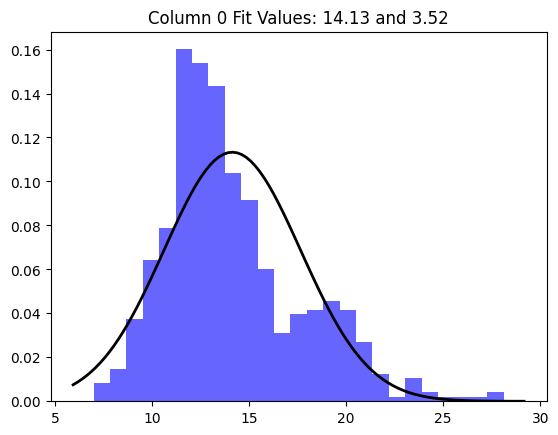

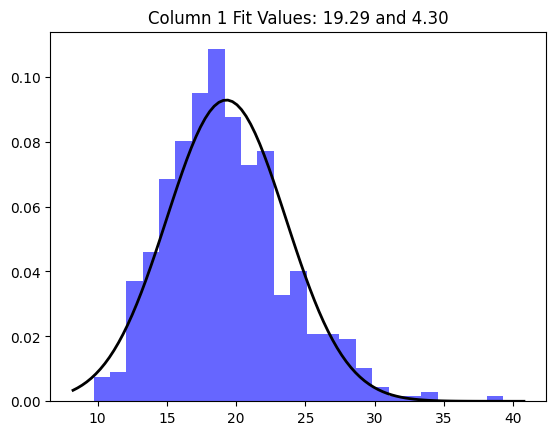

In [62]:
for col in list(df.columns[0:2]): hist_with_normal(df[col],25)

## Threshold Helper

In [99]:
import pandas as pd
from sklearn.metrics import *
def threshold_helper(model,X_train=X_train,y_train=y_train):
    y_pred_proba = model.predict_proba(X_train)
    cuts = [.01*k for k in range(0,100)]
    accuracy, f1, precision, recall = ([],[],[],[])
    for threshold in cuts:
        y_pred = [1 if y[1] >= threshold else 0 for y in y_pred_proba]
        accuracy_scores = accuracy_score(y_pred, y_train)
        accuracy.append(accuracy_scores)
        f1_scores = f1_score(y_pred, y_train)
        f1.append(f1_scores)
        precision_scores = precision_score(y_pred, y_train)
        precision.append(precision_scores)
        recall_scores = recall_score(y_pred, y_train)
        recall.append(recall_scores)
    cut_df = pd.DataFrame({
    "accuracy":accuracy
    ,"f1":f1
    ,"precision":precision
    ,"recall":recall
    },index =cuts)
    cmt = ""
    for col in cut_df.columns:
        cmt += "Max {} of {} at {}\n".format(col,cut_df[col].max(),cut_df[col].idxmax())
    cut_df.plot.line(title = cmt)
    return cut_df

,accuracy,f1,precision,recall
0.00,0.629108,0.772334,1.000000,0.629108
0.01,0.816901,0.872964,1.000000,0.774566
0.02,0.847418,0.891847,1.000000,0.804805
0.03,0.859155,0.899329,1.000000,0.817073
0.04,0.873239,0.908475,1.000000,0.832298
...,...,...,...,...
0.95,0.896714,0.910569,0.835821,1.000000
0.96,0.896714,0.910569,0.835821,1.000000
0.97,0.875587,0.890269,0.802239,1.000000
0.98,0.842723,0.857143,0.750000,1.000000


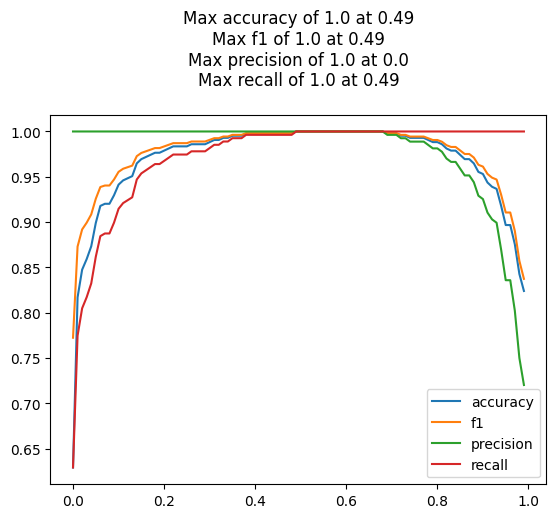

In [100]:
threshold_helper(clf)

## Feature and Permutation Importance

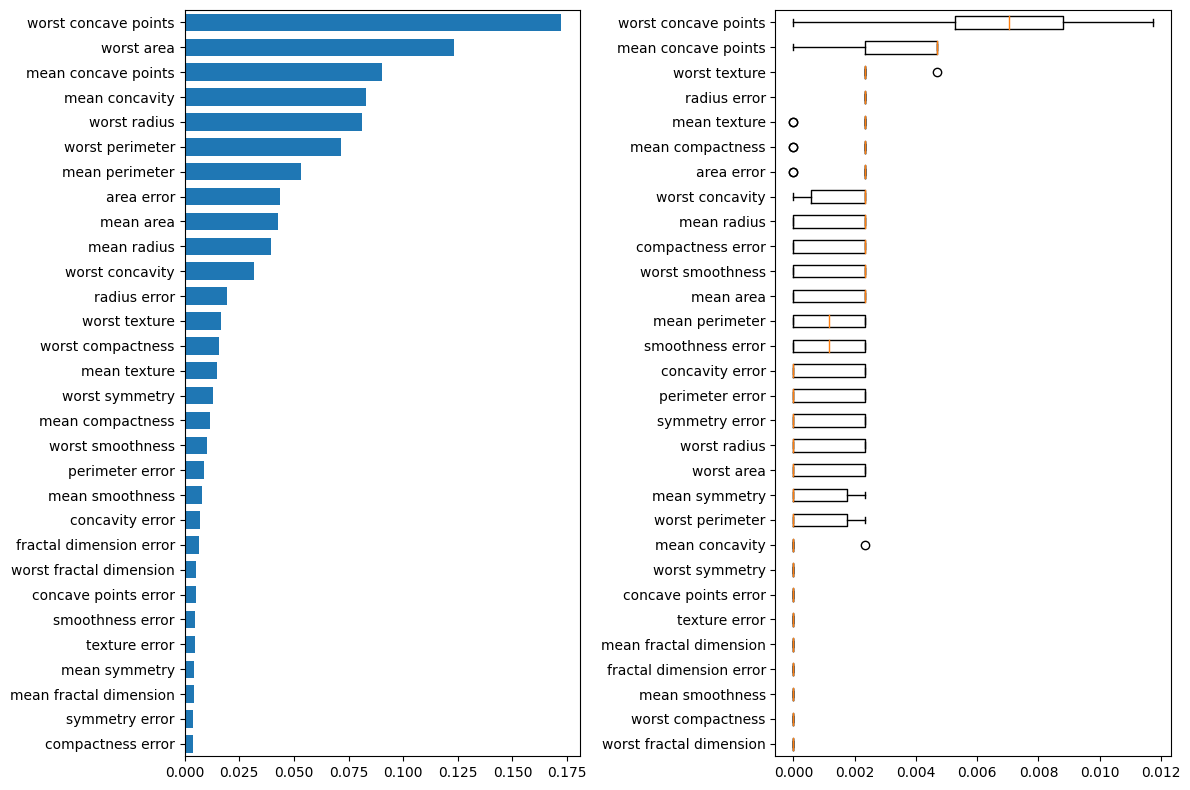

In [6]:
result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(data.feature_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(clf.feature_importances_)))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=data.feature_names[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

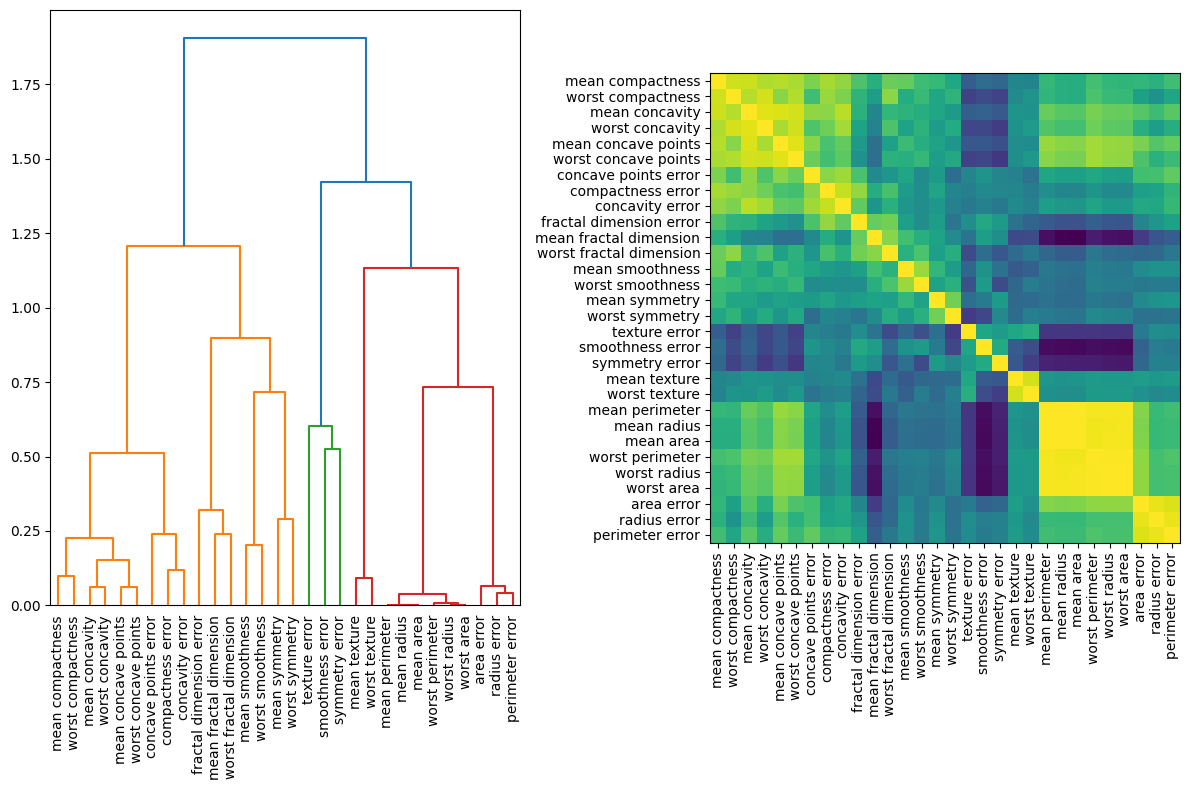

Accuracy on test data with features removed: 0.97


In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=data.feature_names.tolist(), ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()
cluster_ids = hierarchy.fcluster(dist_linkage, 1, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print(
    "Accuracy on test data with features removed: {:.2f}".format(
        clf_sel.score(X_test_sel, y_test)
    )
)